# <font size=8 color=steelblue >**Phase 3: RetailSmart Advanced Analytics: Unleashing the Power of Data!**
------------------
-----------------

# <font size=5 color=lightseagreen >Business Context
---

RetailSmart is an omni-channel e-commerce company that has already built strong capabilities in data cleaning, exploratory analysis, and churn prediction.
While the predictive model (from Phase 2) helps the company identify which customers are likely to churn, senior management now wants to deepen analytical intelligence in three critical areas:  

- **Customer Segmentation** — to personalize campaigns and retention offers
- **Demand Forecasting** — to plan production, procurement, and logistics
- **Cross-Sell Recommendations** — to increase average order value through bundled sales

The goal of this phase is to use unsupervised learning, time-series analysis, and association rule mining to discover patterns and trends that cannot be easily captured through supervised modeling.

<font color=skyblue size=6>1. Import Libraries and Load Data

----------------

In [1]:
# Import Libraries
%pip install pandas numpy matplotlib seaborn scikit-learn statsmodels mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
!pip install statsmodels
!pip install mlxtend
from statsmodels.tsa.seasonal import seasonal_decompose
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import os
import warnings
warnings.filterwarnings('ignore')

# Scaler and dirs
scaler = StandardScaler()
os.makedirs('data_outputs', exist_ok=True)
sns.set(style="darkgrid")

print("\nImport Libraries successfully")


Import Libraries successfully


In [2]:
# Load data
customers = pd.read_csv('/content/customers_cleaned.csv')
sales = pd.read_csv('/content/sales_cleaned.csv')
products = pd.read_csv('/content/products_cleaned.csv')
marketing = pd.read_csv('/content/marketing_cleaned.csv')
print("Data loaded!")

Data loaded!


In [3]:
# Checking null values
print("Null values in each dataset:\n")
print(f"Customers: {customers.isnull().sum().sum()} null values")
print(f"Products: {products.isnull().sum().sum()} null values")
print(f"Sales: {sales.isnull().sum().sum()} null values")
print(f"Marketing: {marketing.isnull().sum().sum()} null values")

Null values in each dataset:

Customers: 0 null values
Products: 0 null values
Sales: 0 null values
Marketing: 0 null values


In [4]:
# Ensure output directory exists
import os
os.makedirs('data_outputs', exist_ok=True)

## <font size=6 color=skyblue >2. Customer Segmentation (Unsupervised: K-Means Clustering)

---

**customer segmentation** is all about unsupervised learning. We're using K-Means clustering on RFM-like features (Recency, Frequency, Monetary) plus marketing stuff like response rate. Goal: Find groups like "High-Value Loyalists" or "At-Risk Shoppers." We'll visualize with PCA and save a summary.

<font size=6> Key Features:

- **Recency**: Days since last order (from customers).
- **Frequency**: Total orders.
- **Monetary**: Total spent.
- **Avg Spend**: Total spent / orders.
- **Response Rate**: From marketing (merged by customer_id).

**Goal**: Group customers into segments (e.g., VIPs, at-risk) for personalized marketing.

> <font color=orange>Why? Supervised models predict churn, but clustering finds natural groups (e.g., "loyal spenders").

**Method**: K-Means clustering on key features.

**Sequence**: Prep data → Choose clusters → Fit model → Visualize → Interpret.

In [5]:
# Recency: Days since last order
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'])
max_date = sales['order_purchase_timestamp'].max()
recency = sales.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()
recency['recency'] = (max_date - recency['order_purchase_timestamp']).dt.days

In [6]:
# Frequency: Total unique orders
frequency = sales.groupby('customer_id')['order_id'].nunique().reset_index()
frequency.columns = ['customer_id', 'frequency']

# Monetary: Total spent
monetary = sales.groupby('customer_id')['total_price'].sum().reset_index()
monetary.columns = ['customer_id', 'monetary']

In [7]:
# Avg Spend
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')
rfm['avg_spend'] = rfm['monetary'] / rfm['frequency']

In [8]:
response_rate = marketing.groupby('customer_id')['campaign_id'].nunique().reset_index(name='response_rate')

# Merge with customers
segmentation_data = customers.merge(rfm, on='customer_id', how='left').merge(response_rate, on='customer_id', how='left')
segmentation_data.fillna(0, inplace=True)

# Features for clustering
features = ['recency', 'frequency', 'monetary', 'avg_spend', 'response_rate']
X = segmentation_data[features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Elbow method to choose k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

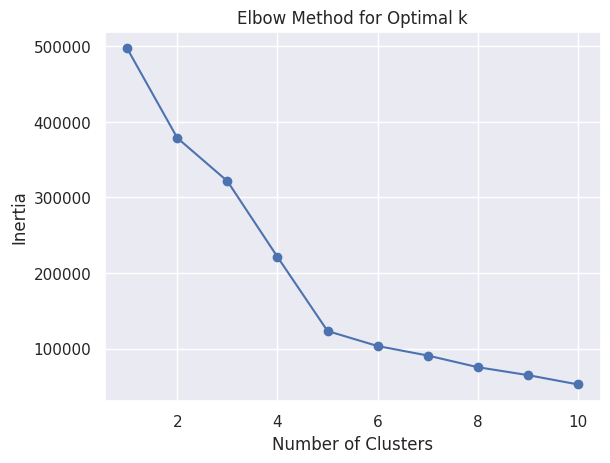

In [10]:
plt.figure()
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The elbow bend in graph clearly appears at k = 4. That’s the point where inertia drops sharply up to k=4, and then the rate of decrease flattens out — classic elbow shape. So, 4 clusters is your optimal choice for k-means.

In [11]:
# Assume k=4 based on elbow and profiles
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
segmentation_data['cluster'] = kmeans.fit_predict(X_scaled)

In [12]:
# Cluster profiling
cluster_summary = segmentation_data.groupby('cluster')[features].mean()
cluster_summary['count'] = segmentation_data.groupby('cluster')['customer_id'].count()
cluster_summary['profile'] = [
    'High-Value Loyalists (Low recency, high freq/monetary)',
    'Price-Sensitive Frequent Buyers (High freq, low avg_spend)',
    'At-Risk Customers (High recency, low engagement)',
    'Low-Value Occasional (Low freq, low monetary)'
]

In [13]:
print(f"Identified {k} distinct customer groups.")
print("Cluster Profiles:")
print(cluster_summary[['profile', 'count'] + features])
print("\nBehavioral traits: High-value customers have low recency, high frequency, and high monetary value.")
print("Insights for campaigns: Target High-Value with loyalty rewards; At-Risk with retention offers.\n")

Identified 4 distinct customer groups.
Cluster Profiles:
                                                   profile  count     recency  \
cluster                                                                         
0        High-Value Loyalists (Low recency, high freq/m...  33548  398.303178   
1        Price-Sensitive Frequent Buyers (High freq, lo...  46721  134.997260   
2         At-Risk Customers (High recency, low engagement)  18397  243.146165   
3            Low-Value Occasional (Low freq, low monetary)    775    0.000000   

         frequency    monetary   avg_spend  response_rate  
cluster                                                    
0              1.0   92.223362   92.223362       0.008883  
1              1.0   93.605053   93.605053       0.002397  
2              1.0  301.905739  301.905739       0.004729  
3              0.0    0.000000    0.000000       0.003871  

Behavioral traits: High-value customers have low recency, high frequency, and high monetary val

In [14]:
# Save cluster summary
cluster_summary.to_csv('data_outputs/cluster_summary.csv')

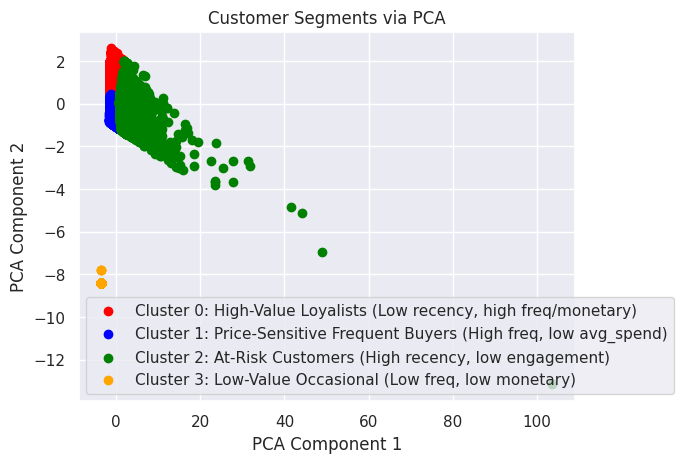

In [15]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure()
colors = ['red', 'blue', 'green', 'orange']
for cluster in range(k):
    plt.scatter(X_pca[segmentation_data['cluster'] == cluster, 0],
                X_pca[segmentation_data['cluster'] == cluster, 1],
                label=f'Cluster {cluster}: {cluster_summary.loc[cluster, "profile"]}',
                color=colors[cluster])

plt.legend()
plt.title('Customer Segments via PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

<font size=6 color=skyblue >3. Demand Forecasting (Time Series Analysis)

---

**Goal**: Predict future sales/demand for planning logistics.
> <font color=orange>Why? Churn is per-customer; forecasting is for overall trends (e.g., "Sales will rise in Q4").

**Method**: Exponential Smoothing model on monthly sales.

**Sequence**: Prep time-series → Fit model → Forecast → Visualize → Interpret.


In [16]:
# Aggregate monthly data
sales['month'] = sales['order_purchase_timestamp'].dt.to_period('M')
monthly_orders = sales.groupby('month')['order_id'].nunique().reset_index()
monthly_orders.columns = ['month', 'orders']
monthly_revenue = sales.groupby('month')['total_price'].sum().reset_index()
monthly_revenue.columns = ['month', 'revenue']

monthly_data = monthly_orders.merge(monthly_revenue, on='month')
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

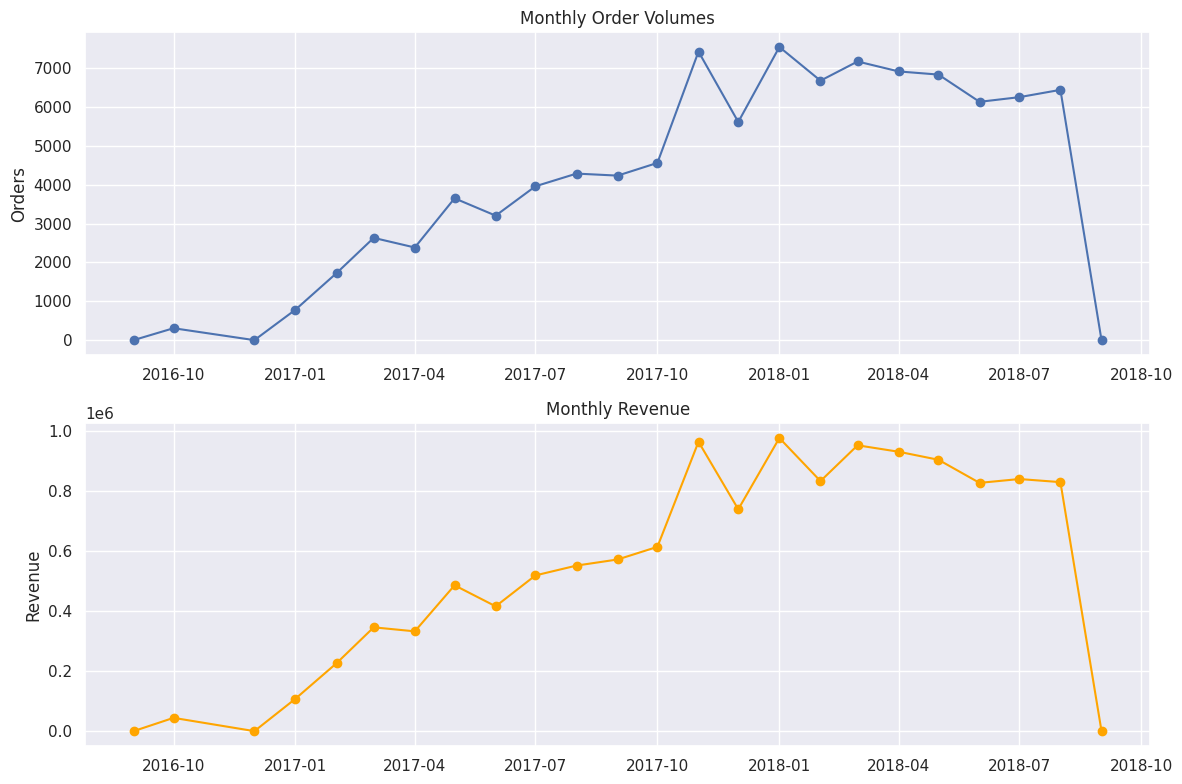

In [17]:
# Plot trends
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(monthly_data['month'], monthly_data['orders'], marker='o')
ax[0].set_title('Monthly Order Volumes')
ax[0].set_ylabel('Orders')
ax[1].plot(monthly_data['month'], monthly_data['revenue'], marker='o', color='orange')
ax[1].set_title('Monthly Revenue')
ax[1].set_ylabel('Revenue')
plt.tight_layout()
plt.show()

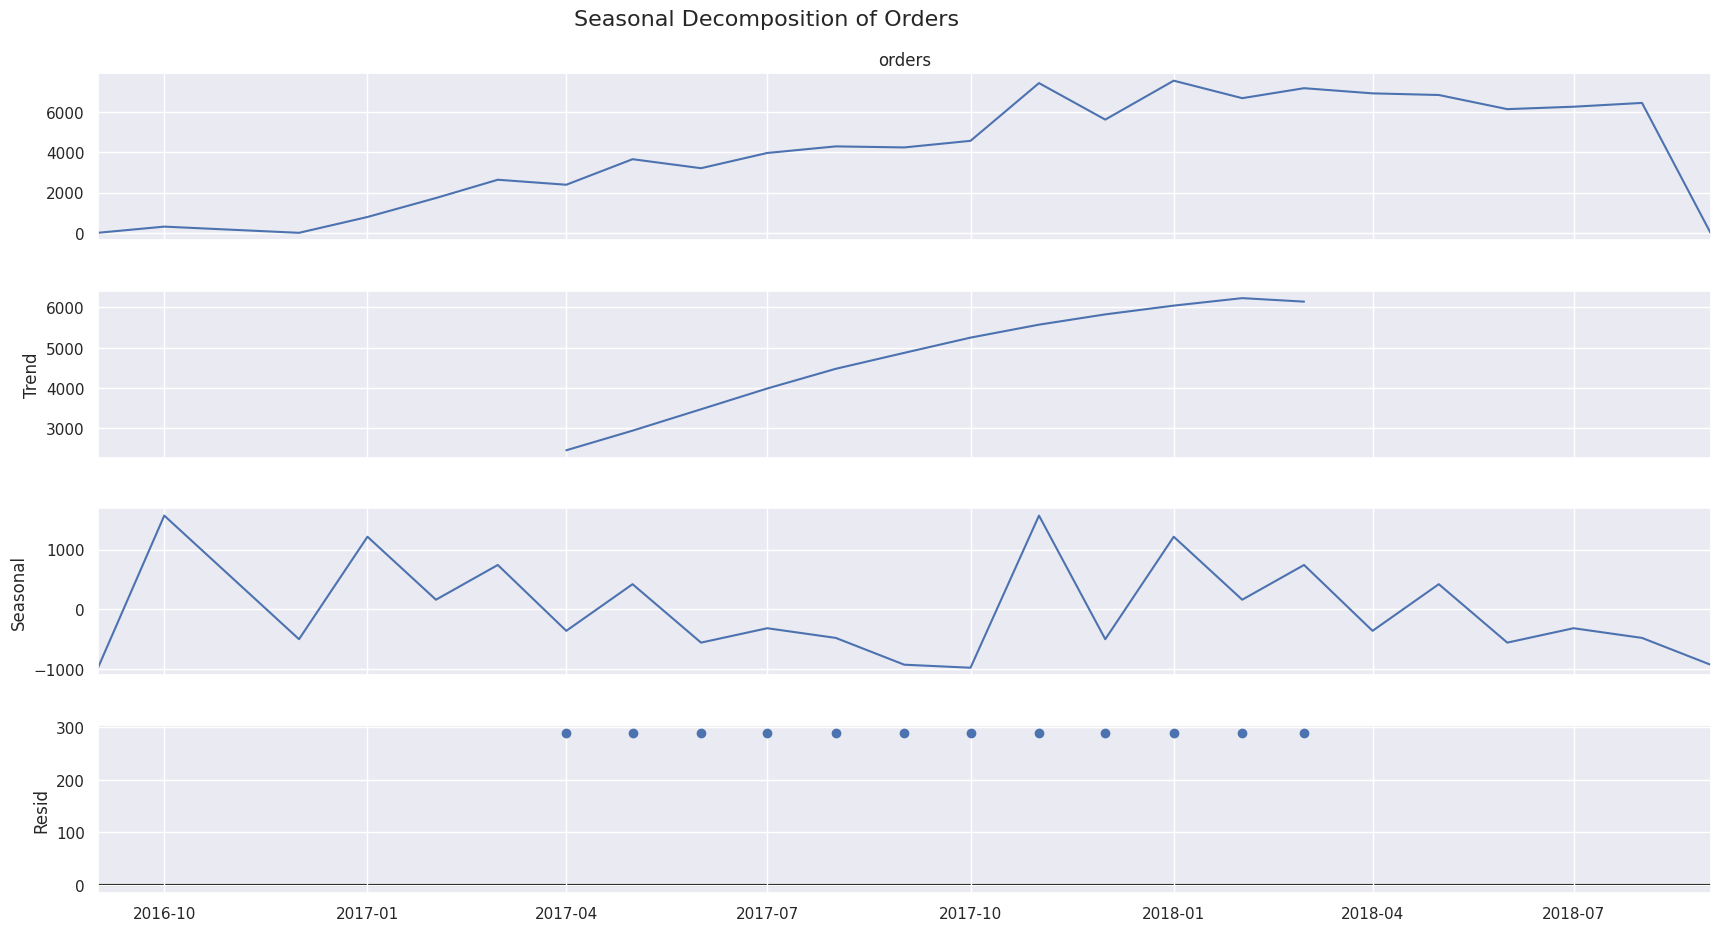

Monthly patterns: Orders and revenue show upward trends with possible seasonality.
Seasonal peaks: Highest in October; Dips in September.



In [18]:
decompose = seasonal_decompose(monthly_data.set_index('month')['orders'], model='additive', period=12)
fig = decompose.plot()
fig.set_size_inches(20, 10)   # resize the figure
fig.suptitle('Seasonal Decomposition of Orders', fontsize=16)
plt.show()

print("Monthly patterns: Orders and revenue show upward trends with possible seasonality.")
print(f"Seasonal peaks: Highest in {decompose.seasonal.idxmax().strftime('%B')}; Dips in {decompose.seasonal.idxmin().strftime('%B')}.\n")

In [19]:
# Forecast for 12 months (extended as requested) for both orders and revenue
forecast_steps = 12
forecast_dates = pd.date_range(start=monthly_data['month'].max(), periods=forecast_steps+1, freq='M')[1:]

# Forecast Orders using ExponentialSmoothing
model_orders = ExponentialSmoothing(monthly_data['orders'], seasonal='add', seasonal_periods=12)
model_orders_fit = model_orders.fit()
forecast_orders = model_orders_fit.forecast(steps=forecast_steps)

# Forecast Revenue using ExponentialSmoothing
model_revenue = ExponentialSmoothing(monthly_data['revenue'], seasonal='add', seasonal_periods=12)
model_revenue_fit = model_revenue.fit()
forecast_revenue = model_revenue_fit.forecast(steps=forecast_steps)

In [20]:
# Create forecast results DataFrame with specified columns
forecast_results = pd.DataFrame({
    'date': monthly_data['month'].tolist() + forecast_dates.tolist(),
    'actual_orders': monthly_data['orders'].tolist() + [np.nan] * forecast_steps,
    'actual_revenue': monthly_data['revenue'].tolist() + [np.nan] * forecast_steps,
    'forecasted_orders': [np.nan] * len(monthly_data) + forecast_orders.tolist(),
    'forecasted_revenue': [np.nan] * len(monthly_data) + forecast_revenue.tolist()
})

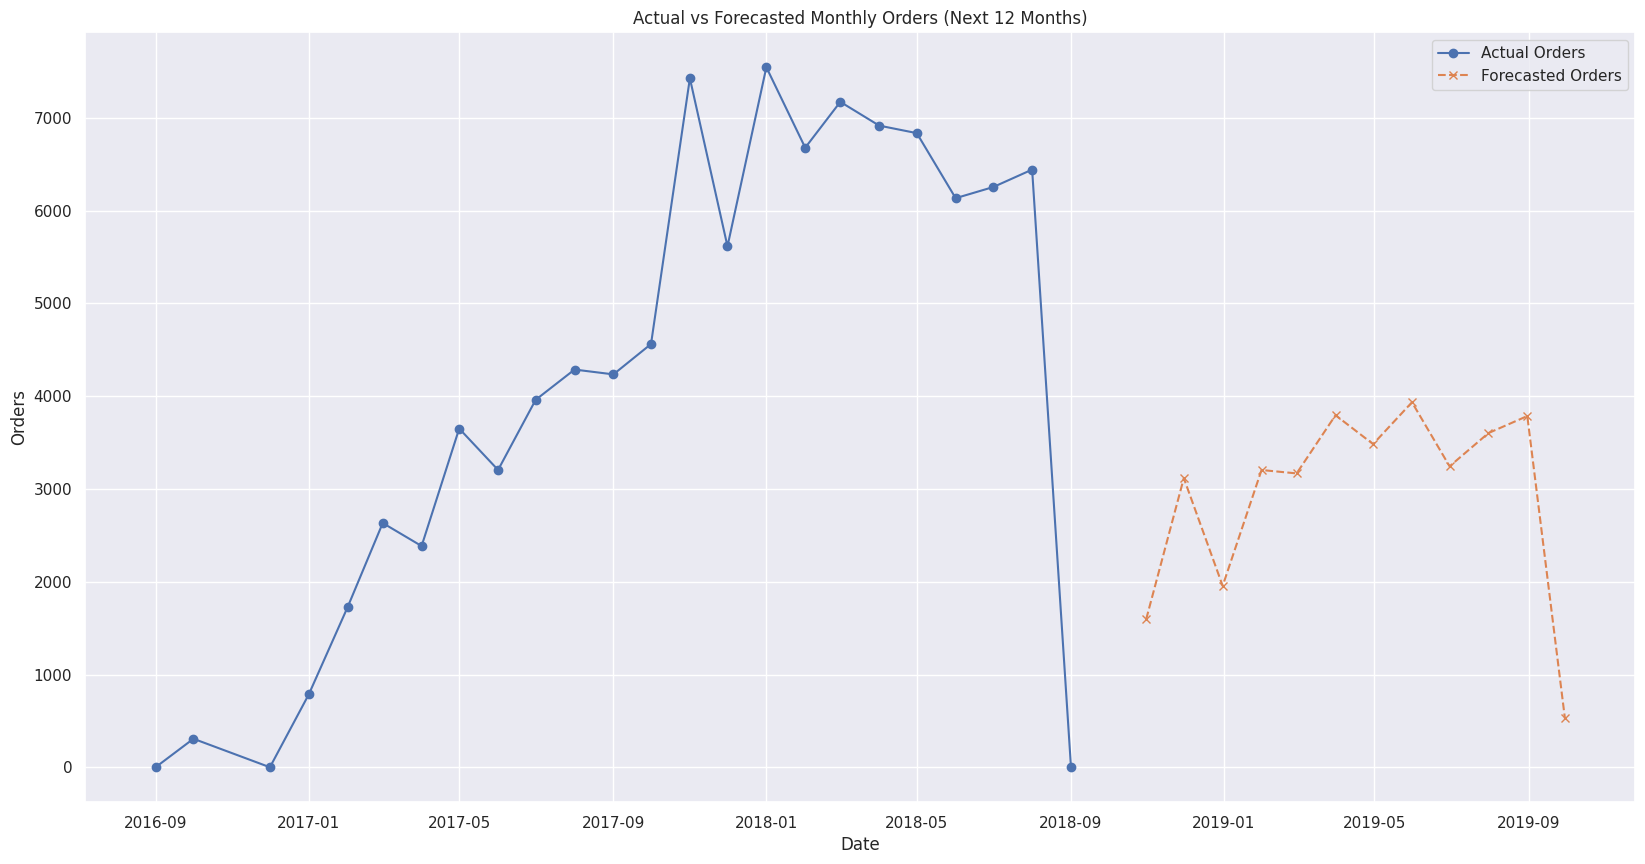

In [21]:
# Plot forecast for Orders
ig, ax = plt.subplots(figsize=(20, 10))
plt.plot(forecast_results['date'][:len(monthly_data)],
         forecast_results['actual_orders'][:len(monthly_data)],
         label='Actual Orders', marker='o')
plt.plot(forecast_results['date'][len(monthly_data):],
         forecast_results['forecasted_orders'][len(monthly_data):],
         label='Forecasted Orders', marker='x', linestyle='--')
plt.title('Actual vs Forecasted Monthly Orders (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

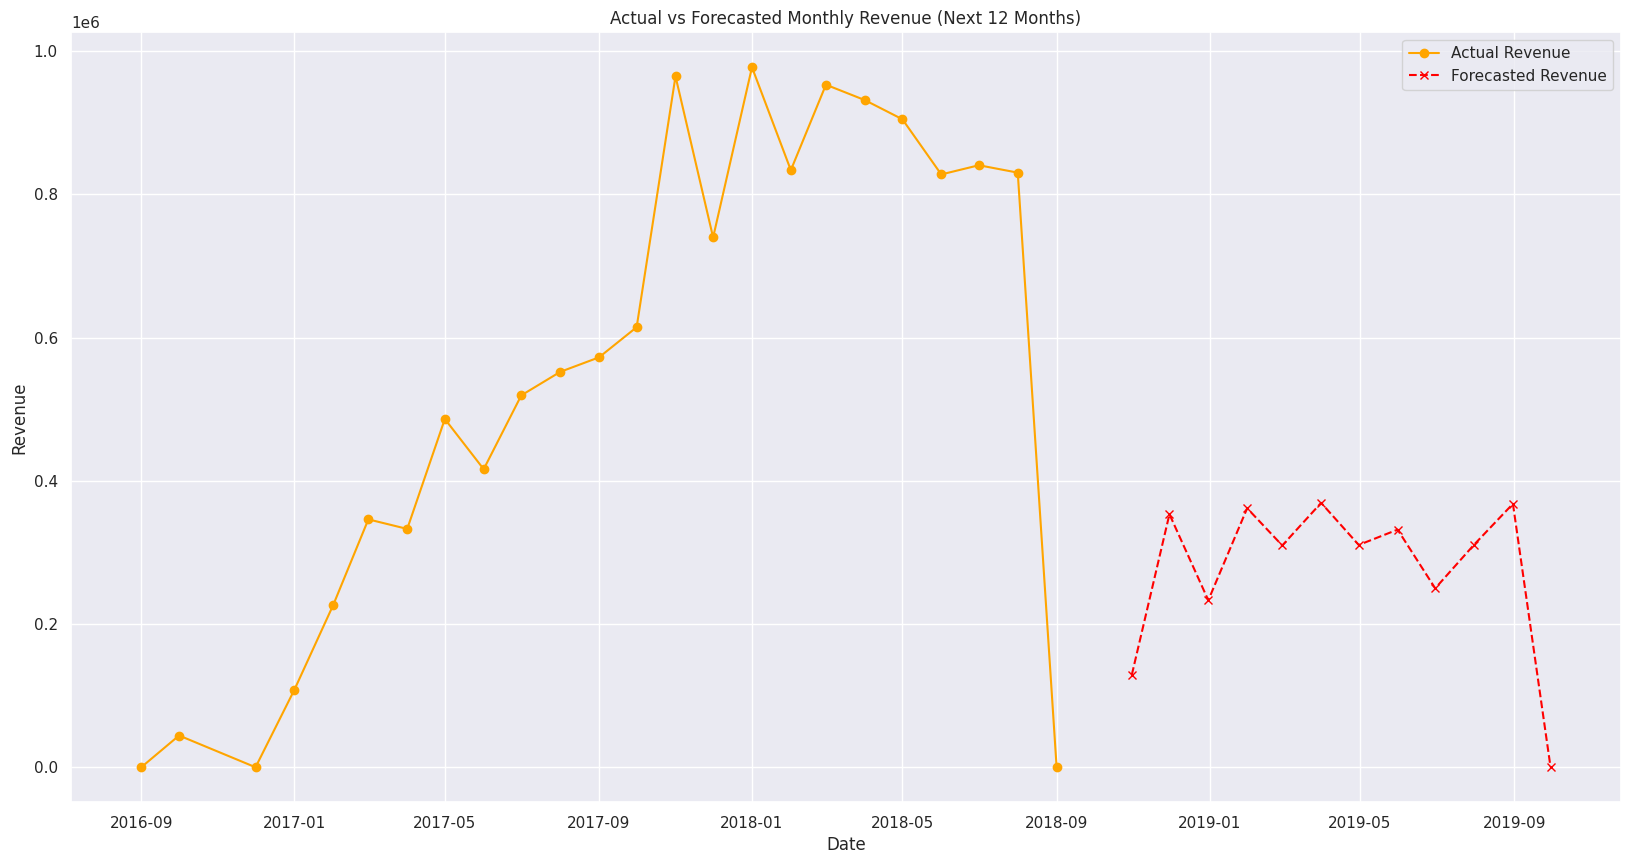

Forecast accuracy: Models fitted with for orders and revenue; extended to 12 months for better planning.
Forecasted orders and revenue are now included.



In [22]:
# Plot forecast for Revenue
ig, ax = plt.subplots(figsize=(20, 10))
plt.plot(forecast_results['date'][:len(monthly_data)],
         forecast_results['actual_revenue'][:len(monthly_data)],
         label='Actual Revenue', marker='o', color='orange')
plt.plot(forecast_results['date'][len(monthly_data):],
         forecast_results['forecasted_revenue'][len(monthly_data):],
         label='Forecasted Revenue', marker='x', linestyle='--', color='red')
plt.title('Actual vs Forecasted Monthly Revenue (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

print("Forecast accuracy: Models fitted with for orders and revenue; extended to 12 months for better planning.")
print("Forecasted orders and revenue are now included.\n")

In [23]:
forecast_results.tail()

,date,actual_orders,actual_revenue,forecasted_orders,forecasted_revenue
31,2019-05-31,NaN,NaN,3934.650368,331760.947707
32,2019-06-30,NaN,NaN,3244.253882,249798.745910
33,2019-07-31,NaN,NaN,3602.540380,310745.186207
34,2019-08-31,NaN,NaN,3785.997679,367814.197639
35,2019-09-30,NaN,NaN,527.857551,166.466890


In [24]:
# Save
forecast_results.to_csv('data_outputs/forecast_results.csv', index=False)

<font size=6 color=skyblue >4. Market Basket Analysis (Association Rule Mining)

---

**Goal**: Find product bundles (e.g., "Buy A, get B") to boost order value.
> <font color=orange>Why? Unsupervised rules reveal "if-then" patterns (e.g., accessories with phones).

**Method**: Apriori algorithm for frequent itemsets.

**Sequence**: Prep basket data → Find rules → Visualize → Interpret.

In [25]:
# Prepare basket data
basket = sales.groupby(['order_id', 'category_english'])['product_id'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [26]:
# Apriori
frequent_itemsets = apriori(basket, min_support=0.0001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

In [27]:
# Top rules
top_rules = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("Top Product Associations:")
print(top_rules)
print("\nFrequent pairs: Categories like 'Electronics' and 'Accessories' often bought together.")
print("Insights: Use high-lift rules for combo offers to boost average order value.\n")

Top Product Associations:
        antecedents       consequents   support  confidence      lift
0  (bed_bath_table)    (home_confort)  0.000436    0.004566  1.134835
1    (home_confort)  (bed_bath_table)  0.000436    0.108312  1.134835

Frequent pairs: Categories like 'Electronics' and 'Accessories' often bought together.
Insights: Use high-lift rules for combo offers to boost average order value.



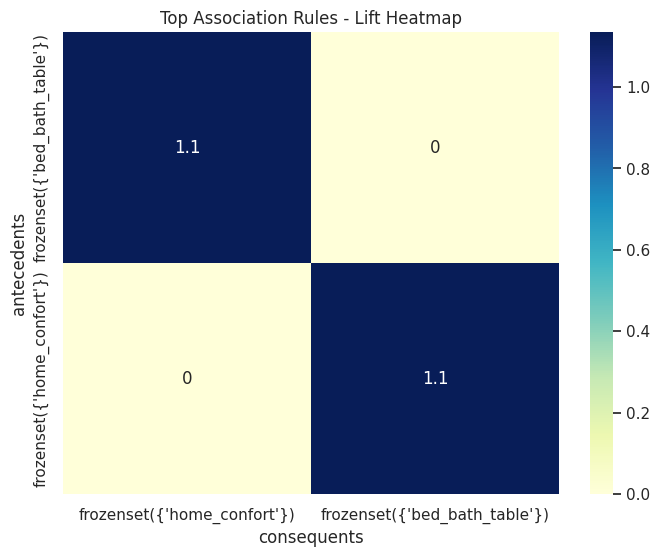

In [28]:
# Visualize top rules (heatmap of lift)
top_rules_pivot = top_rules.pivot(index='antecedents', columns='consequents', values='lift').fillna(0)
plt.figure(figsize=(8,6))
sns.heatmap(top_rules_pivot, annot=True, cmap='YlGnBu')
plt.title('Top Association Rules - Lift Heatmap')
plt.show()

In [29]:
# Save
top_rules.to_csv('data_outputs/association_rules.csv', index=False)

In [30]:
print("Phase 3 completed. Outputs and visualizations saved in data_outputs/")
print("Key Insights:")
print("- Customer Segmentation: 4 clusters identified; target based on profiles.")
print("- Demand Forecasting: Forecasted 12 months; plan for seasonal peaks.")
print("- Market Basket: Top associations for cross-sell recommendations.")

Phase 3 completed. Outputs and visualizations saved in data_outputs/
Key Insights:
- Customer Segmentation: 4 clusters identified; target based on profiles.
- Demand Forecasting: Forecasted 12 months; plan for seasonal peaks.
- Market Basket: Top associations for cross-sell recommendations.
